<a href="https://colab.research.google.com/github/KodakV/BERT/blob/master/BERT_user_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Определение эмоциональной окраски твитов с помощью BERT

In [ ]:
import torch
gpuid=0
if(torch.cuda.is_available()):
    print(torch.cuda.get_device_properties(gpuid))
    torch.cuda.set_device(gpuid)
    device = torch.device(f'cuda:{gpuid}')
else:
    device = torch.device(f'cpu')

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)


In [ ]:
# Если Вы запускаете ноутбук на colab или kaggle,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

!git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git && pip install -r stepik-dl-nlp/requirements.txt
import sys; sys.path.append('./stepik-dl-nlp')

fatal: destination path 'stepik-dl-nlp' already exists and is not an empty directory.


## Установка библиотек

In [ ]:
!pip install pytorch-transformers

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import BertTokenizer, BertConfig
from pytorch_transformers import AdamW, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    print('cpu')
else:
    n_gpu = torch.cuda.device_count()
    print(torch.cuda.get_device_name(0))

Tesla T4


## Загрузка данных


Мы выбрали необычный датасет с разметкой сентимента русскоязычных твитов (подробнее про него в [статье](http://www.swsys.ru/index.php?page=article&id=3962&lang=)). В корпусе, который мы использовали 114,911 положительных и 111,923 отрицательных записей. Загрузить его можно [тут](https://study.mokoron.com/).

In [ ]:
import pandas as pd
user_reviews=pd.read_csv('/content/labeled.csv')
# Если Вы запускаете ноутбук на colab или kaggle, добавьте в начало пути ./stepik-dl-nlp


In [ ]:
user_reviews.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [ ]:
sentences = user_reviews.iloc[:,0].values
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels=[[int(i)] for i in user_reviews.iloc[:,1]]

In [ ]:
sentences[1]

'[CLS] Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.\n [SEP]'

In [ ]:
print(sentences[1000])

[CLS] Смотри чтоб тебя не выебли, петушок) [SEP]


In [ ]:
from sklearn.model_selection import train_test_split

train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.3)

In [ ]:
print(len(train_gt), len(test_gt))

10088 4324


## Inputs

In [ ]:
from pytorch_transformers import BertTokenizer, BertConfig


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in train_sentences]
print (tokenized_texts[0])

['[CLS]', 'н', '##у', 'з', '##а', '##в', '##и', '##с', '##и', '##т', 'о', '##т', 'с', '##ф', '##е', '##р', '##ы', 'к', '##о', '##м', '##п', '##ан', '##ии', 'и', 'п', '##р', '##о', '##е', '##к', '##т', '##а', '.', 'в', 'ф', '##и', '##на', '##н', '##с', '##ов', '##о', '##м', 'а', '##и', '##т', '##и', '-', 'э', '##т', '##о', 'н', '##е', 'р', '##е', '##д', '##к', '##о', '##с', '##т', '##ь', '.', 'н', '##о', 'у', 'н', '##и', '##х', 'и', 'у', '##р', '##ов', '##е', '##н', '##ь', ',', 'в', 'с', '##р', '##е', '##д', '##н', '##е', '##м', ',', 'ч', '##у', '##т', '##ь', 'в', '##ы', '##ш', '##е', 'п', '##о', 'п', '##а', '##л', '##а', '##т', '##е', '.', 'п', '##о', '##м', '##н', '##ю', 'с', '##б', '##е', '##р', 'в', 'с', '##в', '##о', '##е', 'в', '##р', '##е', '##м', '##я', 'в', '##о', '##о', '##б', '##щ', '##е', '30', 'о', '##т', 'р', '##ы', '##н', '##ка', ',', 'д', '##ж', '##а', '##в', '##е', '##р', '##а', '##м', 'д', '##а', '##в', '##а', '##л', 'с', '##х', '##о', '##д', '##у', '.', 'х', '##о', '#

BERTу нужно предоставить специальный формат входных данных.


- **input ids**: последовательность чисел, отождествляющих каждый токен с его номером в словаре.
- **labels**: вектор из нулей и единиц. В нашем случае нули обозначают негативную эмоциональную окраску, единицы - положительную.
- **segment mask**: (необязательно) последовательность нулей и единиц, которая показывает, состоит ли входной текст из одного или двух предложений. Для случая одного предложения получится вектор из одних нулей. Для двух: <length_of_sent_1> нулей и <length_of_sent_2> единиц.
- **attention mask**: (необязательно) последовательность нулей и единиц, где единицы обозначают токены предложения, нули - паддинг.

In [ ]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(
    input_ids,
    maxlen=400,
    dtype="long",
    truncating="post",
    padding="post"
)
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (701 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (715 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, train_gt, 
    random_state=42,
    test_size=0.1
)

train_masks, validation_masks, _, _ = train_test_split(
    attention_masks,
    input_ids,
    random_state=42,
    test_size=0.1
)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)

In [ ]:
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
train_labels

tensor([[0],
        [0],
        [0],
        ...,
        [1],
        [1],
        [1]])

In [ ]:
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(
    train_data,
    sampler=RandomSampler(train_data),
    batch_size=16
)

In [ ]:
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_dataloader = DataLoader(
    validation_data,
    sampler=SequentialSampler(validation_data),
    batch_size=16
)

## Обучение модели

Загружаем [BertForSequenceClassification](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/pytorch_pretrained_bert/modeling.py#L1129):

In [ ]:
from pytorch_transformers import AdamW, BertForSequenceClassification

Аналогичные модели есть и для других задач:

In [ ]:
from pytorch_transformers import BertForQuestionAnswering, BertForTokenClassification

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)



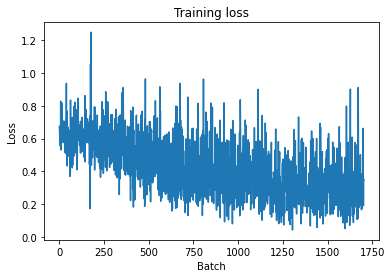

Loss на обучающей выборке: 1.25828


In [ ]:
from IPython.display import clear_output

# Будем сохранять loss во время обучения
# и рисовать график в режиме реального времени
train_loss_set = []
train_loss = 0


# Обучение
# Переводим модель в training mode
model.train()
epochs=3
for epoch in range(epochs):
  for step, batch in enumerate(train_dataloader):
      # добавляем батч для вычисления на GPU
      batch = tuple(t.to(device) for t in batch)
      # Распаковываем данные из dataloader
      b_input_ids, b_input_mask, b_labels = batch
      
      # если не сделать .zero_grad(), градиенты будут накапливаться
      optimizer.zero_grad()
      
      # Forward pass
      loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)

      train_loss_set.append(loss[0].item())  
      
      # Backward pass
      loss[0].backward()
      
      # Обновляем параметры и делаем шаг используя посчитанные градиенты
      optimizer.step()

      # Обновляем loss
      train_loss += loss[0].item()
      
      # Рисуем график
      clear_output(True)
      plt.plot(train_loss_set)
      plt.title("Training loss")
      plt.xlabel("Batch")
      plt.ylabel("Loss")
      plt.show()
      
  print("Loss на обучающей выборке: {0:.5f}".format(train_loss / len(train_dataloader)))




In [ ]:
# Валидация
# Переводим модель в evaluation mode
model.eval()

valid_preds, valid_labels = [], []

for batch in validation_dataloader:   
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для валидационных данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)     
    valid_preds.extend(batch_preds)
    valid_labels.extend(batch_labels)

print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 86.52%


In [ ]:
print("Процент правильных предсказаний на валидационной выборке: {0:.2f}%".format(
    accuracy_score(valid_labels, valid_preds) * 100
))

Процент правильных предсказаний на валидационной выборке: 86.52%


# Оценка качества на отложенной выборке

In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=100,
    dtype="long",
    truncating="post",
    padding="post"
)

Token indices sequence length is longer than the specified maximum sequence length for this model (755 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (702 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (856 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1041 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=32
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 85.45%


In [ ]:
print('Неправильных предсказаний: {0}/{1}'.format(
    sum(test_labels != test_preds),
    len(test_labels)
))

TypeError: ignored

### Домашнее задание

Скачайте датасет с отзывами на фильмы. Например, используйте датасет [IMDB Dataset of 50K Movie Reviews](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews). 

Используйте для дообучения BERT датасет IMDB. 

Ответьте на вопросы:
1. удалось ли достичь такого же accuracy (98\%) при использовании IMDB датасета?
2. удалось ли получить хорошее качество классификации всего за одну эпоху?
3. подумайте, в чем может быть причина различий в дообучении одной и той же модели на разных датасетах
    - Внимательно изучите датасет с русскими твитами. В чем его особенности? Нет ли явных паттернов или ключевых слов, которые однозначно определяют сентимент твита?
    - Попробуйте удалить пунктуацию из датасета с русскими твитами и перезапустите дообучение модели. Изменилось ли итоговое качество работы модели? Почему?

In [ ]:
pos_texts = pd.read_csv('/content/positive.csv', encoding='utf8', sep=';', header=None)
neg_texts = pd.read_csv('/content/negative.csv', encoding='utf8', sep=';', header=None)

In [ ]:
sentences = np.concatenate([pos_texts[3].values, neg_texts[3].values])
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = [[1] for _ in range(pos_texts.shape[0])] + [[0] for _ in range(neg_texts.shape[0])]

In [ ]:
train_sentences, test_sentences, train_gt, test_gt = train_test_split(sentences, labels, test_size=0.2)

In [ ]:
print(sentences[100])

[CLS] @jolechka3 получается,осторожно котлетку перекладываю в др.посуду) [SEP]


In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in test_sentences]
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

input_ids = pad_sequences(
    input_ids,
    maxlen=300,
    dtype="long",
    truncating="post",
    padding="post"
)

In [ ]:
attention_masks = [[float(i>0) for i in seq] for seq in input_ids]

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(test_gt)

prediction_data = TensorDataset(
    prediction_inputs,
    prediction_masks,
    prediction_labels
)

prediction_dataloader = DataLoader(
    prediction_data, 
    sampler=SequentialSampler(prediction_data),
    batch_size=16
)

In [ ]:
model.eval()
test_preds, test_labels = [], []

for batch in prediction_dataloader:
    # добавляем батч для вычисления на GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Распаковываем данные из dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    # При использовании .no_grad() модель не будет считать и хранить градиенты.
    # Это ускорит процесс предсказания меток для тестовых данных.
    with torch.no_grad():
        logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Перемещаем logits и метки классов на CPU для дальнейшей работы
    logits = logits[0].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Сохраняем предсказанные классы и ground truth
    batch_preds = np.argmax(logits, axis=1)
    batch_labels = np.concatenate(label_ids)  
    test_preds.extend(batch_preds)
    test_labels.extend(batch_labels)

In [ ]:
acc_score = accuracy_score(test_labels, test_preds)
print('Процент правильных предсказаний на отложенной выборке составил: {0:.2f}%'.format(
    acc_score*100
))

Процент правильных предсказаний на отложенной выборке составил: 46.37%
